<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Anonymous-Functions" data-toc-modified-id="Anonymous-Functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Anonymous Functions</a></span></li><li><span><a href="#Named-Functions" data-toc-modified-id="Named-Functions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Named Functions</a></span></li><li><span><a href="#Get-Differences" data-toc-modified-id="Get-Differences-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Get Differences</a></span><ul class="toc-item"><li><span><a href="#Figures" data-toc-modified-id="Figures-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Figures</a></span><ul class="toc-item"><li><span><a href="#Comparison-of-Energy-Tolerances" data-toc-modified-id="Comparison-of-Energy-Tolerances-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>Comparison of Energy Tolerances</a></span></li><li><span><a href="#Comparison-of-Full-vs-Freeze" data-toc-modified-id="Comparison-of-Full-vs-Freeze-4.1.2"><span class="toc-item-num">4.1.2&nbsp;&nbsp;</span>Comparison of Full vs Freeze</a></span></li></ul></li></ul></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Conclusions</a></span></li></ul></div>

# Setup

In [1]:
import pandas as pd 
import numpy as np 
import pickle as pkl
import ase
import seaborn as sns
import matplotlib.pyplot as plt

with open("tidy_data/decoupling_assumption_data.pkl", "rb") as file_in:
    raw_data = pkl.load(file_in)


raw_df = pd.DataFrame(raw_data[1])
raw_df.head()

,ediff,method,positions,when
0,None,None,"[[4.6506500020202965, 0.0, 2.320274220484821],...",before
1,1e-04,freeze,"[[4.6506500020202965, 0.0, 2.320274220484821],...",after
2,1e-05,freeze,"[[4.6506500020202965, 0.0, 2.320274220484821],...",after
3,1e-04,full,"[[4.660861427945597, 0.0, 2.320274220484821], ...",after
4,1e-05,full,"[[4.6650580279724325, 0.0, 2.320274220484821],...",after


In [2]:
ediff_04_df = raw_df[raw_df.ediff == "1e-04"]
ediff_05_df = raw_df[raw_df.ediff == "1e-05"]
ediff_04_df.head()

,ediff,method,positions,when
1,1e-04,freeze,"[[4.6506500020202965, 0.0, 2.320274220484821],...",after
3,1e-04,full,"[[4.660861427945597, 0.0, 2.320274220484821], ...",after


# Anonymous Functions

In [3]:
get_stats = lambda x: [np.mean(x),np.std(x)/(np.sqrt(len(x)))]

# Named Functions

In [4]:
def get_bonds_angles(pos):
    O,H1,H2 = [j for i in pos for j in i][-3:]
    sys = raw_data[0]
    del sys[:]
    sys.extend(ase.Atom(symbol='O'))
    sys.extend(ase.Atom(symbol='H'))
    sys.extend(ase.Atom(symbol='H'))
    sys[0].position = O
    sys[1].position = H1
    sys[2].position = H2
    bonds = sys.get_all_distances(mic=True)[0,1:]
    angle = sys.get_angle(1,0,2,mic=True)
    
    return bonds,angle

def get_differences(df):
    full_pos = df[df.method == "full"].positions.values
    freeze_pos = df[df.method == "freeze"].positions.values
    diff_pos = full_pos-freeze_pos
    mag_diff = [np.linalg.norm(j) for i in diff_pos for j in i]

    bonds_full, angle_full = get_bonds_angles(full_pos)
    bonds_freeze, angle_freeze = get_bonds_angles(freeze_pos)

    ediff = df.ediff.tolist()[0]
    avg_diff, avg_diff_err = get_stats(mag_diff)
    bond_full_avg, bond_full_avg_err = get_stats(bonds_full)
    bond_freeze_avg, bond_freeze_avg_err = get_stats(bonds_freeze)
    max_diff = max(mag_diff)
    
    differences = {'ediff':ediff, 'avg_diff':avg_diff, 'avg_diff_err':avg_diff_err, 
                   'max_diff':max_diff, 'bond_full_avg':bond_full_avg, 'bond_full_avg_err':bond_full_avg_err, 
                   'bond_freeze_avg':bond_freeze_avg, 'bond_freeze_avg_err':bond_freeze_avg_err,
                   'angle_full':angle_full, 'angle_freeze':angle_freeze}
    
    return differences



# Get Differences

In [5]:
results_df = pd.DataFrame({1e-4:get_differences(ediff_04_df), 1e-5:get_differences(ediff_05_df)})

In [6]:
#results_df = results_df.T
results_df.T


,angle_freeze,angle_full,avg_diff,avg_diff_err,bond_freeze_avg,bond_freeze_avg_err,bond_full_avg,bond_full_avg_err,ediff,max_diff
0.00010,105.313,105.032,0.00839832,0.000962119,0.973133,2.81355e-06,0.973411,2.80845e-06,1e-04,0.0306407
0.00001,105.313,105.038,0.00973549,0.00109409,0.973133,2.81355e-06,0.973416,2.80877e-06,1e-05,0.0331539


In [7]:
df = results_df.copy()
df = df.T
df.reset_index()
vals_1 = df.iloc[0,:].apply(float)
vals_2 = df.iloc[1,:].apply(float)

## Figures

### Comparison of Energy Tolerances

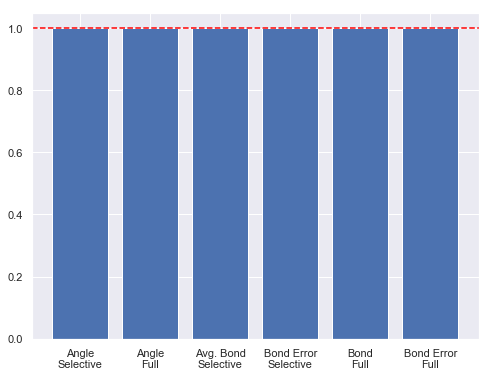

In [8]:
sns.set();

y=vals_1/vals_2
y = [j for i,j in enumerate(y) if i not in [2,3,8,9]]
x=np.arange(len(y))

labels = ["Angle\nSelective","Angle\nFull","Avg. Bond\nSelective","Bond Error\nSelective","Bond\nFull","Bond Error\nFull"]

plt.figure(figsize=(8,6));
#plt.title("Ratio of Different Structural Parameters\nEDIFF: 1E-4/1E-5",size=16);
plt.bar(x,y);
plt.gca().axhline(1.0,ls="--",color="red")
plt.xticks(x,labels);

### Comparison of Full vs Freeze

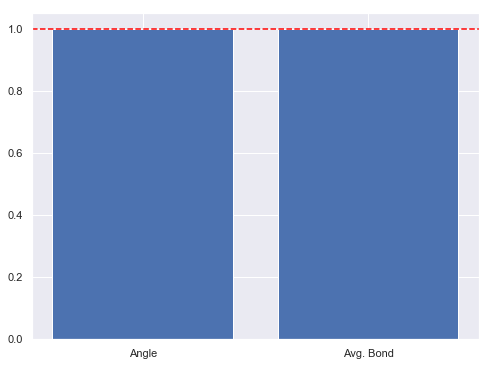

In [9]:
y2 = [y[0]/y[1],y[2]/y[4]]
x2 = np.arange(len(y2))
labels2 = ["Angle","Avg. Bond"]

plt.figure(figsize=(8,6));
#plt.title("Ratio of Different Structural Parameters\nFull vs Selective",size=16);
plt.bar(x2,y2);
plt.gca().axhline(1.0,ls="--",color="red")
plt.xticks(x2,labels2);

# Conclusions

1. EDIFF = 1e-4 is sufficient
    - See from first figure that ratio of all structural parameters is nearly unity.
2. Reasonable to decouple.
    - See from second figure that ratio of sutructural parameter is nearly unity